Model type: <class 'sklearn.linear_model._base.LinearRegression'>
Generating SHAP summary plot...


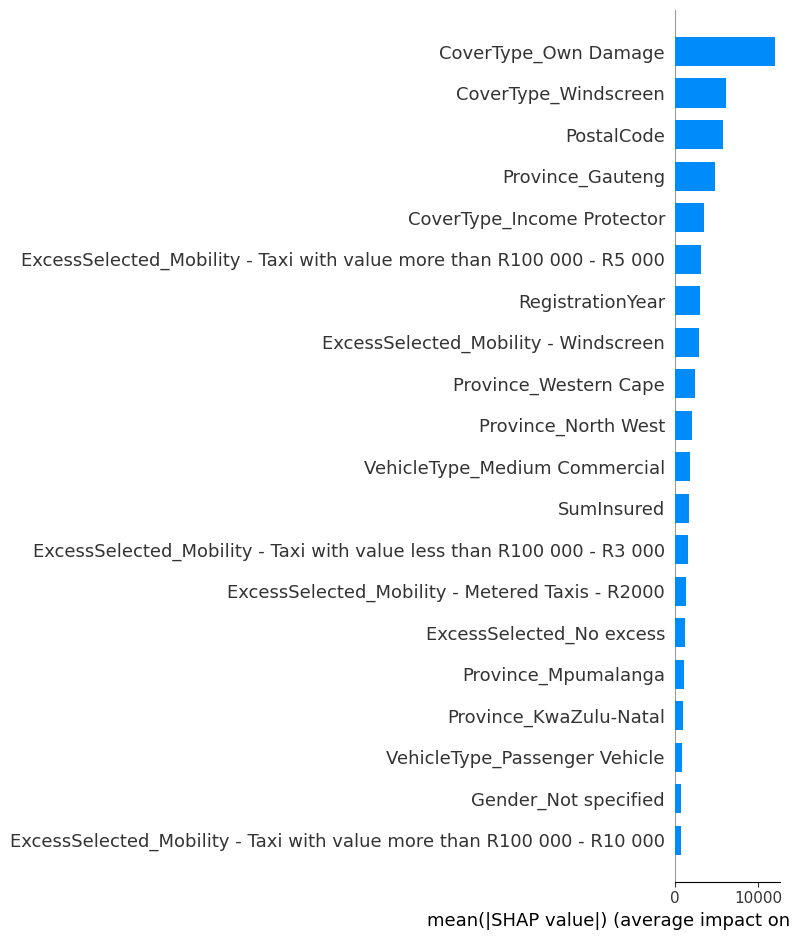

SHAP summary plot saved as reports/feature_importance.png

Top 10 Features Influencing Claims:
                                              feature    importance
33                               CoverType_Own Damage  11977.892318
36                               CoverType_Windscreen   6182.212946
0                                          PostalCode   5748.396729
5                                    Province_Gauteng   4866.143453
31                         CoverType_Income Protector   3499.930077
21  ExcessSelected_Mobility - Taxi with value more...   3086.453332
1                                    RegistrationYear   3039.771932
24               ExcessSelected_Mobility - Windscreen   2941.141211
11                              Province_Western Cape   2439.643255
9                                 Province_North West   2081.505102

Generating SHAP dependence plots for top features...
Saved SHAP dependence plot for 'CoverType_Own Damage' as reports/shap_dependence_CoverType_Own_Damage.p

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [12]:
# 0. For Jupyter inline plotting
%matplotlib inline

import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import os

# Ensure 'reports' directory exists
os.makedirs('reports', exist_ok=True)

# 1. Load preprocessed training data
X_train = pd.read_csv('output/X_train.csv')
y_train = pd.read_csv('output/y_train.csv').squeeze()

# 2. Load trained pipeline (preprocessor + regressor)
model_pipe = joblib.load('output/best_model.joblib')

# 3. Extract preprocessor and regressor from pipeline
preprocessor = model_pipe.named_steps['preprocessor']
regressor = model_pipe.named_steps['regressor']

# 4. Extract feature names after preprocessing
numeric_features = preprocessor.named_transformers_['num'].feature_names_in_.tolist()
categorical_features = preprocessor.named_transformers_['cat'].feature_names_in_.tolist()
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

# 5. Preprocess X_train data
X_train_processed = preprocessor.transform(X_train)
if hasattr(X_train_processed, "toarray"):  # if sparse matrix
    X_train_processed = X_train_processed.toarray()

print(f"Model type: {type(regressor)}")

# 6. Create SHAP explainer and calculate SHAP values
if 'RandomForest' in str(type(regressor)) or 'XGBRegressor' in str(type(regressor)):
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_train_processed)
elif 'LinearRegression' in str(type(regressor)) or 'Linear' in str(type(regressor)):
    explainer = shap.Explainer(regressor, X_train_processed)
    shap_values = explainer(X_train_processed)
else:
    raise ValueError(f"SHAP does not support model type: {type(regressor)}")

# 7. Generate SHAP summary plot (bar)
print("Generating SHAP summary plot...")
shap.summary_plot(
    shap_values.values if hasattr(shap_values, "values") else shap_values,
    X_train_processed,
    feature_names=feature_names,
    plot_type='bar',
    show=True
)

plt.gcf().savefig('reports/feature_importance.png')
print("SHAP summary plot saved as reports/feature_importance.png")

# 8. Show top 10 features by mean absolute SHAP value
shap_vals_array = shap_values.values if hasattr(shap_values, "values") else shap_values
importance = np.abs(shap_vals_array).mean(axis=0)
shap_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
top_features = shap_df.sort_values('importance', ascending=False).head(10)

print("\nTop 10 Features Influencing Claims:")
print(top_features)

# 9. Generate SHAP dependence plots for top features
print("\nGenerating SHAP dependence plots for top features...")
for feature in top_features['feature']:
    plt.figure(figsize=(8,6))
    shap.dependence_plot(
        feature,
        shap_values.values if hasattr(shap_values, "values") else shap_values,
        X_train_processed,
        feature_names=feature_names,
        show=False
    )
    safe_feature_name = feature.replace(" ", "_").replace(":", "_")
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.savefig(f'reports/shap_dependence_{safe_feature_name}.png')
    plt.close()
    print(f"Saved SHAP dependence plot for '{feature}' as reports/shap_dependence_{safe_feature_name}.png")

# 10. Business interpretation example (to include in your report)
print("""
Business Interpretation:
- SHAP values quantify the contribution of each feature to the prediction for each instance.
- Positive SHAP values indicate the feature increases predicted claim severity; negative values decrease it.
- For example, if 'CoverType_Own Damage' has high positive SHAP values, policies with this coverage type are predicted to have higher claims.
- Geographic features (e.g., 'Province_Gauteng') might indicate regional risk differences, affecting premiums.
- Features related to mobility or vehicle age can show how changes influence risk—e.g., older vehicles tend to have higher claims.
- These insights can inform risk-based premium adjustments and targeted marketing strategies.
""")
